# Load libraries

In [ ]:
!pip install scikeras tensorflow

In [ ]:
# standard
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle, re, os, shutil, joblib, time
from tqdm import tqdm
import pprint # pretty printing dictionaries
import cv2

# classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier


# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

# for k-fold cross-validation
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

Mounted at /content/drive
deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  1022  100  1022    0     0  13583      0 --:--:-- --:--:-- --:--:-- 13626
OK
56 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:

#Set feature name

In [ ]:
feature_name = 'sobel'

# Load data

In [ ]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1723138135,"nanos":249736549},"severity":"INFO","message":"Start gcsfuse/2.4.0 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1723138135,"nanos":249931339},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"MaxRetryAttempts\":0,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"RetryMultiplier\":2,\"Tem

In [ ]:
#specify input image folder
input_path = os.path.join(local_path, 'feature_matrices')
input_feature_path = os.path.join(local_path, 'features')

# Create output directory if it doesn't exist
output_path = os.path.join(local_path, 'weights')
os.makedirs(output_path, exist_ok=True)
os.listdir(f"{input_feature_path}")

['kmeans_model.pkl',
 'sift_test_features_matrix_95.pkl',
 'sift_train_features_matrix_95.pkl',
 'sift_val_features_matrix_95.pkl',
 'test_canny.pkl',
 'test_canny_pca_95.pkl',
 'test_canny_std.pkl',
 'test_cnn.pkl',
 'test_cnn_pca_95.pkl',
 'test_cnn_std.pkl',
 'test_hog.pkl',
 'test_hog_pca_95.pkl',
 'test_hog_std.pkl',
 'test_sift.pkl',
 'test_sift_pca_95.pkl',
 'test_sift_std.pkl',
 'test_sobel.pkl',
 'test_sobel_pca_95.pkl',
 'test_sobel_std.pkl',
 'tfidf_transformer.pkl',
 'train_canny.pkl',
 'train_canny_pca_95.pkl',
 'train_canny_std.pkl',
 'train_cnn.pkl',
 'train_cnn_pca_95.pkl',
 'train_cnn_std.pkl',
 'train_hog.pkl',
 'train_hog_pca_95.pkl',
 'train_hog_std.pkl',
 'train_sift.pkl',
 'train_sift_pca_95.pkl',
 'train_sift_std.pkl',
 'train_sobel.pkl',
 'train_sobel_pca_95.pkl',
 'train_sobel_std.pkl',
 'validation_canny.pkl',
 'validation_canny_pca_95.pkl',
 'validation_canny_std.pkl',
 'validation_cnn.pkl',
 'validation_cnn_pca_95.pkl',
 'validation_cnn_std.pkl',
 'validatio

## Load train and validation labels

In [ ]:
def load_image_labels(input_path):
    train_lb = pickle.load(open(input_path + '/' + 'train_label'  + '.pkl', 'rb'))
    val_lb = pickle.load(open(input_path + '/' + 'validation_label' + '.pkl', 'rb'))
    test_lb = pickle.load(open(input_path + '/' + 'test_label' + '.pkl', 'rb'))

    return train_lb, val_lb, test_lb

In [ ]:
#load the labels from file in drive
df_train_label = load_image_labels(input_path)[0]
df_val_label = load_image_labels(input_path)[1]
df_test_label = load_image_labels(input_path)[2]


## Load Train and Validation Features

In [ ]:
def load_feature_matrices(input_path):
    train_fm = pickle.load(open(input_path + '/train_' + feature_name + '_pca_95.pkl', 'rb'))
    val_fm = pickle.load(open(input_path + '/validation_' + feature_name + '_pca_95.pkl', 'rb'))
    test_fm = pickle.load(open(input_path + '/test_' + feature_name + '_pca_95.pkl', 'rb'))

    return train_fm, val_fm, test_fm

In [ ]:
# loading feature matrics for each set
x_train = load_feature_matrices(input_feature_path)[0]
x_val = load_feature_matrices(input_feature_path)[1]
x_test = load_feature_matrices(input_feature_path)[2]

In [ ]:
# # Convert to numpy arrays
# x_train = np.array(list(x_train.values()))
# x_val = np.array(list(x_val.values()))
# x_test = np.array(list(x_test.values()))

In [ ]:
# get indices for feature matrices
train_fm_ind = pickle.load(open(local_path + '/features' + '/train_sift_std'  + '.pkl', 'rb'))
val_fm_ind = pickle.load(open(local_path + '/features' + '/validation_sift_std' + '.pkl', 'rb'))
test_fm_ind = pickle.load(open(local_path + '/features' + '/test_sift_std' + '.pkl', 'rb'))

In [ ]:
# create dataframe with image filename as the indices
df_train = pd.DataFrame({feature_name: [vector for vector in x_train]}, index = list(train_fm_ind.keys()))
df_val = pd.DataFrame({feature_name: [vector for vector in x_val]}, index = list(val_fm_ind.keys()))
df_test = pd.DataFrame({feature_name: [vector for vector in x_test]}, index = list(test_fm_ind.keys()))

In [ ]:
# join feature dataframes with labels and groups on the indices
# puting df_{set}_label on the left to preserve suffled image orders
df_train = df_train_label.join(df_train, on=None, how='left', validate='one_to_one')
df_val = df_val_label.join(df_val, on=None, how='left', validate='one_to_one')
df_test = df_test_label.join(df_test, on=None, how='left', validate='one_to_one')

## Combine train and validation feature dataframes

In [ ]:
# combine train and val dataframes
df = pd.concat([df_train, df_val], axis=0)
df.head()

,label,group,sobel
image,,,
N25_100EK113_03030540.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[72.00268684355585, -9.917861380040964, 14.593..."
N25_100EK113_03030542.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[75.03470468020295, -9.986655253930103, 15.727..."
N25_100EK113_03030539.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[74.21485896132529, -8.90705844797895, 14.8459..."
N25_100EK113_03030541.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[75.44893240936217, -9.333218177926913, 16.350..."
N25_100EK113_03030538.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[81.33515382285462, -8.309362273391699, 17.625..."


In [ ]:
df['label'].value_counts()

,count
label,
Peccary,1231
Black Agouti,1230
Dasypus Species,1229
Spotted Paca,1228
South American Coati,1117
Bos Species,1110


# Grouped k-fold cross validation for all feature vectors

- Based on https://www.linkedin.com/pulse/hyperparameter-tuning-gridsearchcv-hands-on-example-svm-dujmovic-qj3kf/
- ROC for multiclass: https://scikit-learn.org/dev/auto_examples/model_selection/plot_roc.html
- Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
#data prep
X_train = np.vstack(df[feature_name].to_numpy())
y_train = df['label']
groups_train = df['group']
splits = 3

#shuffle data
X_train, y_train, groups_train = shuffle(X_train, y_train, groups_train, random_state=281)

#convert string categories to integers
label_encoder = LabelEncoder()
y_train_cat = label_encoder.fit_transform(y_train)
# y_train_cat = tf.keras.utils.to_categorical(np.asarray(y_train.factorize()[0]), len(np.unique(y_train)))

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [ ]:
X_train.shape[1]

2105

In [ ]:
#group function for cross fold validation
gkf = GroupKFold(n_splits=splits)

In [ ]:
# fix random seed for reproducibility
seed = 281
tf.random.set_seed(seed)

In [ ]:
#define NN model, for KerasClassifier
def create_NN(activation, neurons, dropout_rate, weight_constraint):
 # create model
 model = Sequential()
 model.add(Dense(neurons, input_shape=(X_train.shape[1],), activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
 model.add(Dense(neurons, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
 model.add(Dropout(dropout_rate))
 model.add(Dense(6,  kernel_initializer='uniform', activation='softmax'))
 # Compile model
 model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

In [ ]:
#grid search parameter

activation = ['relu', 'tanh',  'linear']
neurons = [100, 200, 300]
weight_constraint = [2.0, 3.0, 4.0]
dropout_rate = [0.2, 0.4, 0.6]

param_grid = dict(model__activation=activation,
                  model__neurons=neurons,
                  model__weight_constraint=weight_constraint,
                  model__dropout_rate=dropout_rate)

In [ ]:
#create model
model = KerasClassifier(model=create_NN, epochs=5, verbose=0)

In [ ]:
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=gkf,
                           scoring='accuracy',
                           verbose=2,
                           n_jobs=-1)


intermediate_path = output_path + '/nn_grid_search_'+ feature_name +'intermediate.pkl'

if os.path.exists(intermediate_path):
    saved_state = joblib.load(intermediate_path)
    grid_search = saved_state['grid_search']
    print(f"Resuming grid search from iteration {last_iteration}.")
else:
    last_iteration = 0
    print("Starting new grid search.")

with tqdm(total=len(param_grid), desc="Grid Search") as pbar:
    def callback(*args, **kwargs):
        pbar.update(1)
        if pbar.n % 5 == 0:
            joblib.dump({
                'grid_search': grid_search,
                'last_iteration': pbar.n,
            }, intermediate_path)

    original_fit = grid_search.fit

    def fit_with_callback(*args, **kwargs):
        original_fit(*args, **kwargs)
        callback()

    grid_search.fit = fit_with_callback

    grid_search.fit(X_train, y_train_cat, groups=groups_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_score = grid_search.best_score_
print("Best score found: ", best_score)

best_model= grid_search.best_estimator_
pickle.dump(best_model, open(output_path + '/nn_best_model_'+ feature_name +'.pkl', 'wb'))
joblib.dump(grid_search, output_path + '/nn_grid_search_final_'+ feature_name +'.pkl')

Starting new grid search.


Grid Search:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Grid Search:  25%|██▌       | 1/4 [05:39<16:59, 339.97s/it]


Best parameters found:  {'model__activation': 'relu', 'model__dropout_rate': 0.4, 'model__neurons': 200, 'model__weight_constraint': 4.0}
Best score found:  0.7123875658506981


['/mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/weights/nn_grid_search_final_sobel.pkl']

In [ ]:
os.listdir(f"{output_path}")

['grid_search_final.pkl',
 'grid_search_final_polynomial.pkl',
 'lda_best_model.pkl',
 'lda_best_model_0801.pkl',
 'lda_canny_lsqr_best_model.pkl',
 'lda_canny_lsqr_grid_search_final.pkl',
 'lda_canny_lsqr_train_score.pkl',
 'lda_cnn_lsqr_best_model.pkl',
 'lda_cnn_lsqr_grid_search_final.pkl',
 'lda_cnn_lsqr_train_score.pkl',
 'lda_grid_search_final.pkl',
 'lda_grid_search_final_0801.pkl',
 'lda_hog_eigen_best_model.pkl',
 'lda_hog_eigen_grid_search_final.pkl',
 'lda_hog_eigen_train_score.pkl',
 'lda_hog_lsqr_best_model.pkl',
 'lda_hog_lsqr_grid_search_final.pkl',
 'lda_hog_lsqr_train_score.pkl',
 'lda_hog_svd_best_model.pkl',
 'lda_hog_svd_grid_search_final.pkl',
 'lda_hog_svd_train_score.pkl',
 'lda_sift_best_model.pkl',
 'lda_sift_grid_search_final.pkl',
 'lda_sift_lsqr_best_model.pkl',
 'lda_sift_lsqr_grid_search_final.pkl',
 'lda_sift_lsqr_train_score.pkl',
 'lda_sift_train_score.pkl',
 'lda_sobel_lsqr_best_model.pkl',
 'lda_sobel_lsqr_grid_search_final.pkl',
 'lda_sobel_lsqr_trai

# Model Evaluation

In [ ]:
# # load best-performing model from grid search
# best_model = pickle.load(open(output_path + '/nn_best_model.pkl', 'rb'))

##Confusion Matrix for Testing

In [ ]:
X_test = np.vstack(df_test[feature_name].to_numpy())
y_test = df_test['label']
groups_test = df_test['group']

#convert string categories to integers
# y_test_cat = tf.keras.utils.to_categorical(np.asarray(y_test.factorize()[0]), len(np.unique(y_test)))
# Encode the test labels using the loaded label encoder
y_test_cat = label_encoder.transform(y_test)
print("Encoded labels:", y_test_cat)
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Encoded labels: [3 3 3 ... 1 1 1]
Label mapping: {'Black Agouti': 0, 'Bos Species': 1, 'Dasypus Species': 2, 'Peccary': 3, 'South American Coati': 4, 'Spotted Paca': 5}


In [ ]:
# prediction
y_test_pred_cat = best_model.predict(X_test)

Testing accuracy:  0.758082497212932


<Figure size 1500x1500 with 0 Axes>

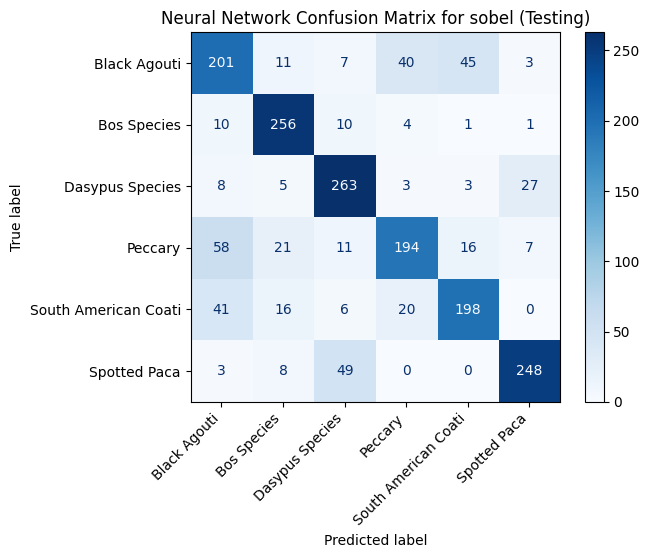

In [ ]:
#confusion matrix
cm_test = confusion_matrix(y_test_cat, y_test_pred_cat)
label_names = label_encoder.classes_

#training accuracy
print("Testing accuracy: ", cm_test.diagonal().sum()/cm_test.sum())

#plot confusion matrix
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('Neural Network Confusion Matrix for '+ feature_name +' (Testing)')
plt.show()

In [ ]:
# save predictions to a folder called predicions path in the local path
predictions_path = os.path.join(local_path, 'predictions')
os.makedirs(predictions_path, exist_ok=True)

pickle.dump(y_test_pred_cat, open(predictions_path + '/nn_y_pred_'+ feature_name +'.pkl', 'wb'))

## ROC

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot = label_binarizer.transform(y_test)
y_scores = best_model.fit(X_train, y_train_cat).predict_proba(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


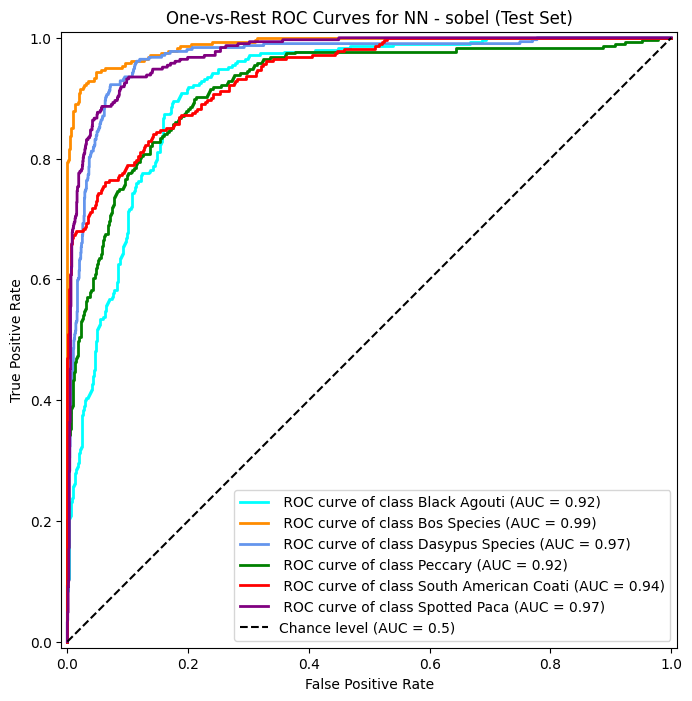

In [ ]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, label in enumerate(label_encoder.classes_):
  class_of_interest = label
  class_id = i

  kwargs = {'lw':2}
  display = RocCurveDisplay.from_predictions(
      y_onehot[:, class_id],
      y_scores[:, class_id],
      name=f' ROC curve of class {class_of_interest}',
      ax=ax,
      color=colors[i],
      plot_chance_level=bool(i==5),
      **kwargs
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title="One-vs-Rest ROC Curves for NN - "+ feature_name+ " (Test Set)",
  )

## Training time for best model

In [ ]:
# Calculate the start time
start = time.time()

# Traing model with best params found
best_param_grid = dict(model__activation=[best_params['model__activation']],
                       model__neurons=[best_params['model__neurons']],
                       model__weight_constraint=[best_params['model__weight_constraint']],
                       model__dropout_rate=[best_params['model__dropout_rate']])

best_grid_search = GridSearchCV(estimator=model,
                                param_grid=best_param_grid,
                                cv=gkf,
                                scoring='accuracy',
                                verbose=0,
                                n_jobs=-1)

best_grid_search.fit(X_train, y_train_cat, groups=groups_train)

# Calculate the end time and time taken
end = time.time()
length = end - start

# Show the results : this can be altered however you like
print("Training time for best model: ", length, "seconds")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training time for best model:  10.748327732086182 seconds
